In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
url = 'http://opendap.tudelft.nl/thredds/dodsC/data2/zandmotor/meteohydro/xband/2016/xband_resolution_200m_2016.nc'

In [3]:
ds = netCDF4.Dataset(url)

In [16]:
lat = ds.variables['Lat'][0]
lon = ds.variables['Lon'][0]

In [49]:
i = 50
current = ds.variables['Current'][i]
wave_period = ds.variables['Period'][i]
wave_length = ds.variables['WaveLgth'][i]
wave_angle = ds.variables['WAngle'][i]

/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


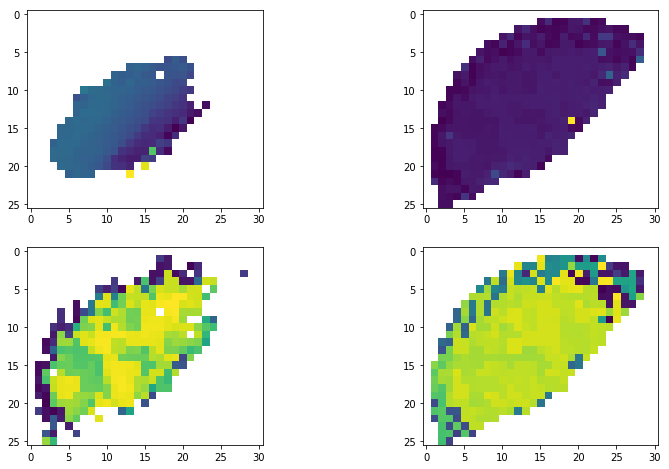

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(13, 8))
axes[0, 0].imshow(current)
axes[0, 1].imshow(wave_period)
axes[1, 0].imshow(wave_length)
axes[1, 1].imshow(wave_angle)